In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [3]:
image = cv2.imread('Jockey/img00001.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/data/maryam.sana/anaconda3/envs/compressai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
masks = mask_generator.generate(image)

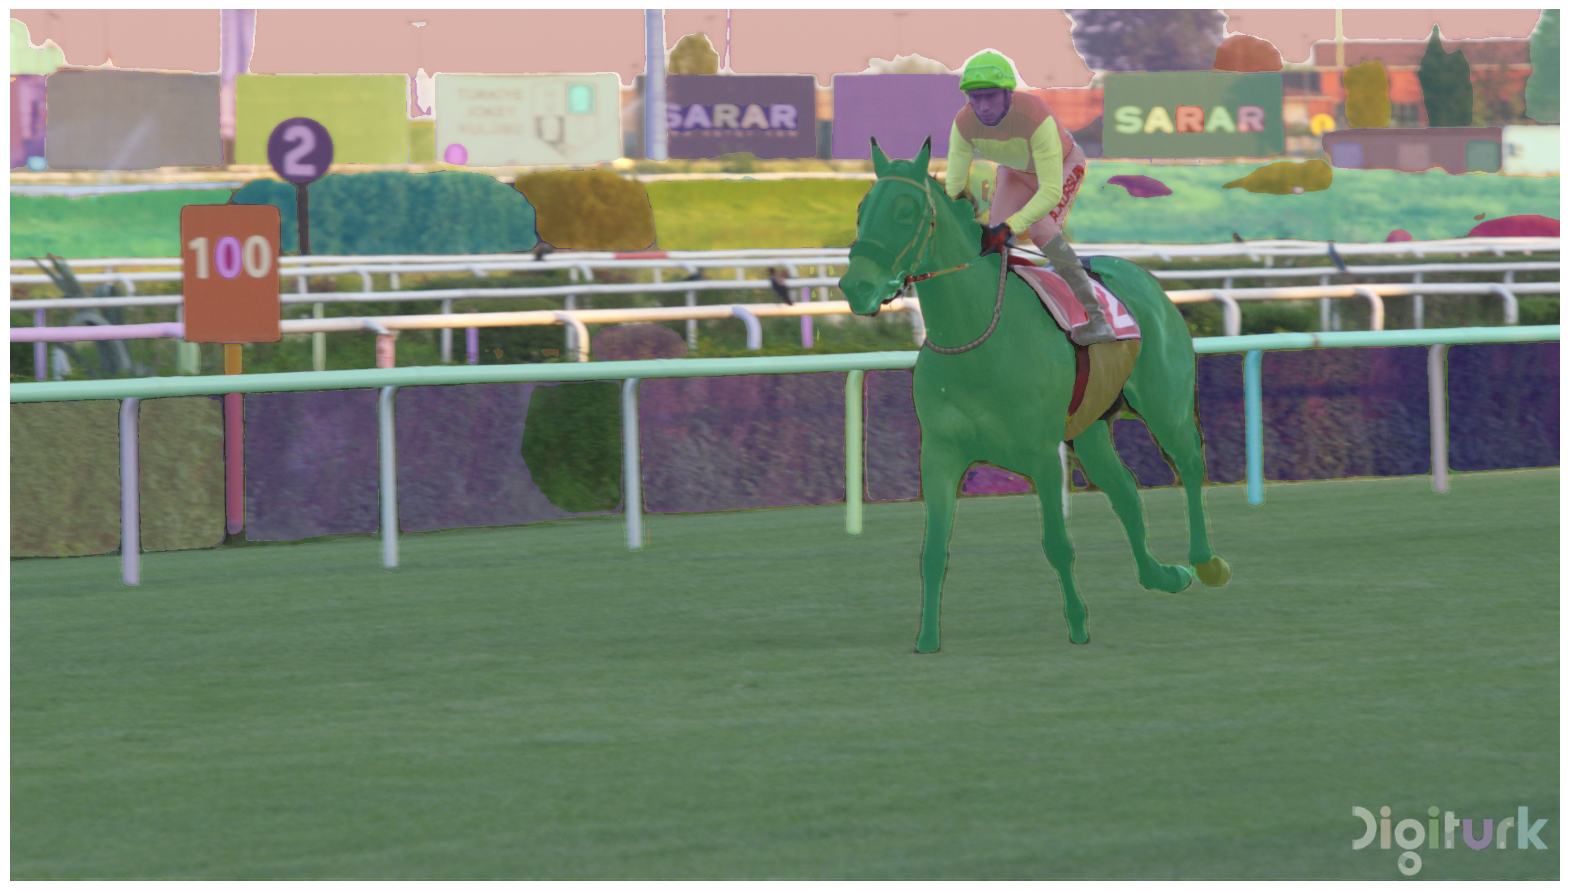

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [8]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 843552,
 'bbox': [0, 423, 1919, 655],
 'predicted_iou': 1.0505192279815674,
 'point_coords': [[1170.0, 624.375]],
 'stability_score': 0.9566754102706909,
 'crop_box': [0, 0, 1920, 1080]}

In [7]:
def create_instance_ids_map(segmentation_dicts, image_shape):
    instance_ids_map = np.zeros(image_shape, dtype=np.uint16)
    instance_id = 1

    for seg_dict in segmentation_dicts:
        seg_mask = seg_dict['segmentation']
        bbox = seg_dict['bbox']
        crop_box = seg_dict['crop_box']

        # Ensure bbox is within the valid range of image_shape
        bbox[0] = max(0, min(bbox[0], image_shape[1]))
        bbox[1] = max(0, min(bbox[1], image_shape[0]))
        bbox[2] = max(0, min(bbox[2], image_shape[1]))
        bbox[3] = max(0, min(bbox[3], image_shape[0]))

        # Adjust bbox coordinates based on crop_box
        bbox = [bbox[0] - crop_box[0], bbox[1] - crop_box[1], 
                 bbox[2] - crop_box[0], bbox[3] - crop_box[1]]
        print(bbox)

        # Resize seg_mask to match the dimensions of the bounding box region
        seg_mask_resized = seg_mask[:bbox[3] - bbox[1], :bbox[2] - bbox[0]]
        print(seg_mask_resized.shape)
        # Assign unique instance ID to each pixel within the bounding box
        instance_ids_map[bbox[1]:bbox[3], bbox[0]:bbox[2]][seg_mask_resized] = instance_id

        # Increment instance ID for the next object
        instance_id += 1

    return instance_ids_map

# Example usage:
image_shape = (1080, 1920)  # Example image shape
instance_ids_map = create_instance_ids_map(masks, image_shape)


[0, 423, 1919, 655]
(232, 1919)
[525, 79, 232, 116]
(37, 1627)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 0 but corresponding boolean dimension is 1627

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def create_colored_segmentation_map(segmentation_dicts):
    instance_ids_map = create_instance_ids_map(segmentation_dicts)
    num_instances = np.max(instance_ids_map)
    
    # Generate a colormap with a unique color for each instance ID
    colors = plt.cm.get_cmap('tab20', num_instances)
    colormap = ListedColormap([colors(i) for i in range(num_instances)])
    
    # Create the colored segmentation map
    plt.imshow(instance_ids_map, cmap=colormap)
    plt.colorbar(ticks=np.arange(0, num_instances))
    plt.title('Colored Segmentation Map')
    plt.show()


create_colored_segmentation_map(masks)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 232 but corresponding boolean dimension is 1080